In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

True
Using device cuda:0


[d2-w4140a-01:10145] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.d2-w4140a-01.614072/jf.0/1004797952/shared_mem_cuda_pool.d2-w4140a-01 could be created.
[d2-w4140a-01:10145] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


Loss with random inputs: 0.000429
Loss with assigned force: 7.98e-11


Text(0.5, 1.0, 'Dolfin Target')

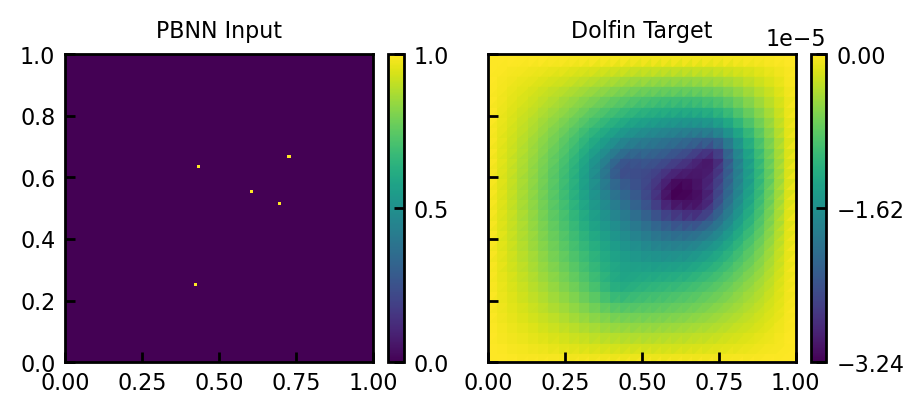

In [2]:
# Load dataset
from data_processing import HDF5Dataset
from mesh_utils import *
from plot_utils import *

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
import dolfin as dlf
dlf.set_log_level(40)

dataset = HDF5Dataset()

fig, ax = plt.subplots(1, 2, figsize=(5,2), sharex=True, sharey=True)
sample = dataset[0]
plot_grid(sample['inputs'][2], sample['inputs'][:2], ax[0])
plot_mesh(sample['output'], dataset.mesh, ax[1])

# Check residual on Jhat
Jhat = sample['Jhat']
f = np.random.random(sample['output'].shape)
print(f'Loss with random inputs: {Jhat(f):.3g}')

f = multichannel_img_to_mesh(
    sample['force'], 
    sample['grid_x'], 
    sample['grid_y'], 
    dataset.build_problem.function_space,
    return_function=False).T.flatten()
print(f'Loss with assigned force: {Jhat(f):.3g}')

ax[0].set_title('PBNN Input')
ax[1].set_title('Dolfin Target')

/tmp/ipykernel_10145/3343536408.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load('../models/poisson_weight.ckpt')


Model reached loss=3.84e-11 at epoch 152
Loss with assigned force: 5.92e-11
Loss with ground truth force: 7.67e-11


(0.0, 1.0, 0.0, 1.0)

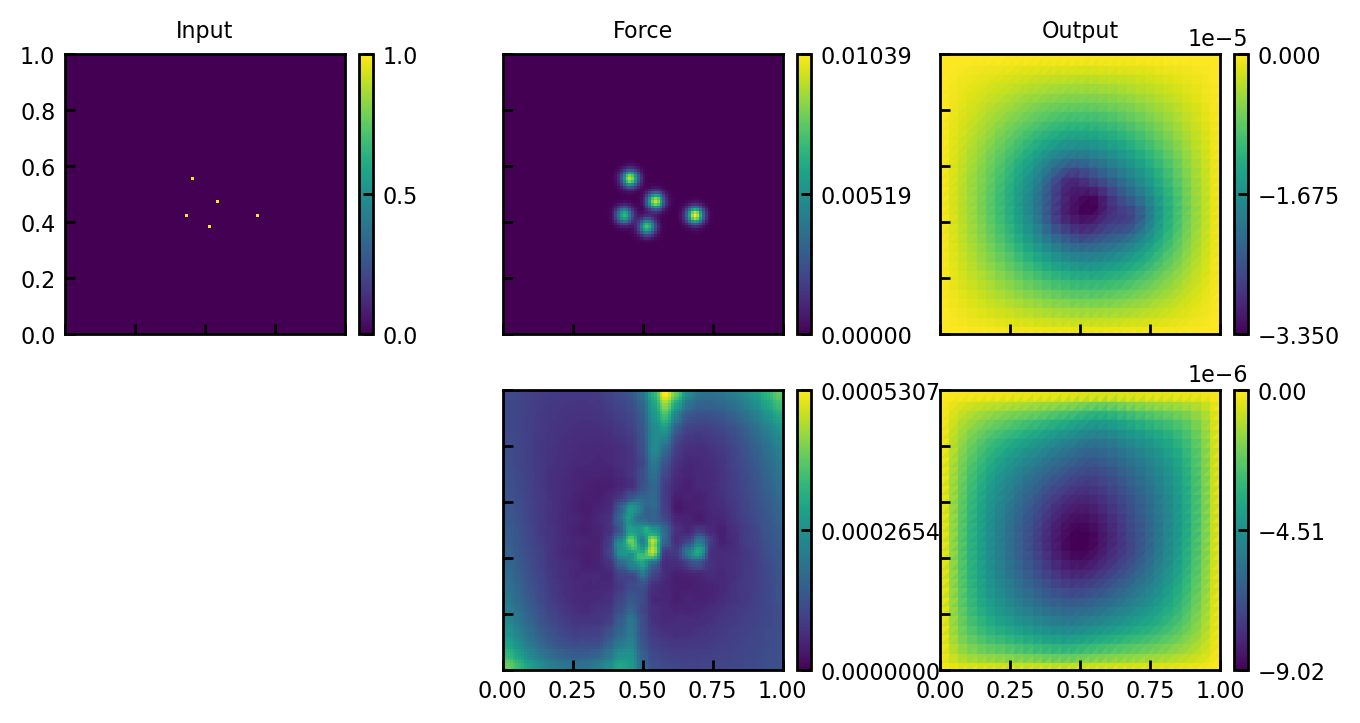

In [5]:
from dolfin_pbnn import DolfinPBNN

# Load model and model weights
model = DolfinPBNN().to(device)
info = torch.load('../models/poisson_weight.ckpt')
model.load_state_dict(info['state_dict'])
print(f'Model reached loss={info["loss"]:.3g} at epoch {info["epoch"]:d}')
model.eval();

fig, ax = plt.subplots(2, 3, figsize=(8,4), sharex=True, sharey=True, squeeze=False)

# Plot ground truth
gen = torch.Generator()
gen.manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=gen)
sample = val_dataset[10]

plot_grid(sample['inputs'][2], sample['inputs'][:2], ax[0,0])
plot_grid(sample['force'][0], sample['inputs'][:2], ax[0,1], vmin=0)
plot_mesh(sample['output'], dataset.mesh, ax[0,2], vmax=0)

# Generate and plot model predictions
force = model(sample['inputs'].to(device))
force = force.detach().cpu()
plot_grid(force[0], sample['inputs'][:2], ax[1,1], vmin=0)

force = multichannel_img_to_mesh(
    force,
    sample['grid_x'], sample['grid_y'],
    sample['function_space'],
    return_function=True,
)
pred = dataset.build_problem.forward(force)
plot_mesh(pred.compute_vertex_values(), dataset.mesh, ax[1,2], vmax=0)

print(f'Loss with assigned force: {sample['Jhat'](force.vector()[:]):.3g}')

f = multichannel_img_to_mesh(
    sample['force'], 
    sample['grid_x'], 
    sample['grid_y'], 
    dataset.build_problem.function_space,
    return_function=False).T.flatten()
print(f'Loss with ground truth force: {Jhat(f):.3g}')

ax[0,0].set_title('Input')
ax[0,1].set_title('Force')
ax[0,2].set_title('Output')

ax[1,0].axis('off')